
---

#**Tecnológico de Monterrey**

##**Maestría en Inteligencia Artificial Aplicada**

###**Curso:** Ciencia y Analítica de Datos

###**Profesora:** Dra. María de la Paz Rico Fernández

###**Actividad:** K-Means 

###**Alumno:** Francisco Javier Ramírez Arias

###**Matrícula:** A01316379

---

Este notebook se basa en información de target
![imagen.png](https://www.america-retail.com/static//2020/12/target01.jpg)


Ahora imagina que somos parte del equipo de data science de la empresa Target, una de las tiendas con mayor presencia en Estados Unidos. El departamento de logistica acude a nosotros para saber donde le conviene poner sus almacenes, para que se optimice el gasto de gasolina, los tiempos de entrega de los productos y se disminuyan costos. Para ello, nos pasan los datos de latitud y longitud de cada una de las tiendas.

https://www.kaggle.com/datasets/saejinmahlauheinert/target-store-locations?select=target-locations.csv

Si quieres saber un poco más de graficas geográficas consulta el siguiente notebook
https://colab.research.google.com/github/QuantEcon/quantecon-notebooks-datascience/blob/master/applications/maps.ipynb#scrollTo=uo2oPtSCeAOz

In [20]:
! pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes
! pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [117]:
import pandas as pd
import numpy as np
from tqdm import tqdm
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import geopandas
import seaborn as sns
from IPython.display import set_matplotlib_formats
from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances_argmin
from geopy.geocoders import Nominatim


Importa la base de datos

In [4]:
url="https://raw.githubusercontent.com/marypazrf/bdd/main/target-locations.csv"
df=pd.read_csv(url)

Exploremos los datos.

In [6]:
df.head()

,name,latitude,longitude,address,phone,website
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1839 non-null   object 
 1   latitude   1839 non-null   float64
 2   longitude  1839 non-null   float64
 3   address    1839 non-null   object 
 4   phone      1839 non-null   object 
 5   website    1839 non-null   object 
dtypes: float64(2), object(4)
memory usage: 86.3+ KB


**Definición de Latitud y Longitud**

**Latitud** Es la distancia en grados, minutos y segundos que hay con respecto al paralelo principal, que es el ecuador (0º). La latitud puede ser norte y sur.

**Longitud**: Es la distancia en grados, minutos y segundos que hay con respecto al meridiano principal, que es el meridiano de Greenwich (0º).La longitud puede ser este y oeste.

In [8]:
latlong=df[["latitude","longitude"]]

¡Visualizemos los datos!, para empezar a notar algún patron. 

A simple vista pudieramos pensar que tenemos algunos datos atípicos u outliers, pero .... no es así, simplemente esta grafica no nos está dando toda la información.

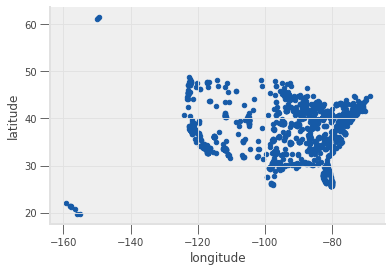

In [115]:
#extrae los datos interesantes
latlong.plot.scatter( "longitude","latitude")

In [10]:
latlong.describe()

,latitude,longitude
count,1839.000000,1839.000000
mean,37.791238,-91.986881
std,5.272299,16.108046
min,19.647855,-159.376962
25%,33.882605,-98.268828
50%,38.955432,-87.746346
75%,41.658341,-80.084833
max,61.577919,-68.742331


Para entender un poco más, nos auxiliaremos de una librería para graficar datos geográficos. Esto nos ayudara a tener un mejor entendimiento de ellos.




In [152]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [12]:
df["Coordinates"] = list(zip(df.longitude, df.latitude))
df["Coordinates"] = df["Coordinates"].apply(Point)
df.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417369999999 33.2242254)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98977789999999 33.3345501)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593169999999 30.6028747)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.9715595 34.5601477)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.4464222 31.2660613)


In [13]:
gdf = gpd.GeoDataFrame(df, geometry="Coordinates")
gdf.head()

,name,latitude,longitude,address,phone,website,Coordinates
0,Alabaster,33.224225,-86.804174,"250 S Colonial Dr, Alabaster, AL 35007-4657",205-564-2608,https://www.target.com/sl/alabaster/2276,POINT (-86.80417 33.22423)
1,Bessemer,33.334550,-86.989778,"4889 Promenade Pkwy, Bessemer, AL 35022-7305",205-565-3760,https://www.target.com/sl/bessemer/2375,POINT (-86.98978 33.33455)
2,Daphne,30.602875,-87.895932,"1698 US Highway 98, Daphne, AL 36526-4252",251-621-3540,https://www.target.com/sl/daphne/1274,POINT (-87.89593 30.60287)
3,Decatur,34.560148,-86.971559,"1235 Point Mallard Pkwy SE, Decatur, AL 35601-...",256-898-3036,https://www.target.com/sl/decatur/2084,POINT (-86.97156 34.56015)
4,Dothan,31.266061,-85.446422,"4601 Montgomery Hwy, Dothan, AL 36303-1522",334-340-1112,https://www.target.com/sl/dothan/1468,POINT (-85.44642 31.26606)


In [14]:
#mapa

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

world.head()

,pop_est,continent,name,gdp_md_est,geometry
iso_a3,,,,,
FJI,920938,Oceania,Fiji,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
TZA,53950935,Africa,Tanzania,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
ESH,603253,Africa,W. Sahara,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
CAN,35623680,North America,Canada,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
USA,326625791,North America,United States of America,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [15]:
#graficar el mapa
world.name.unique()

array(['Fiji', 'Tanzania', 'W. Sahara', 'Canada',
       'United States of America', 'Kazakhstan', 'Uzbekistan',
       'Papua New Guinea', 'Indonesia', 'Argentina', 'Chile',
       'Dem. Rep. Congo', 'Somalia', 'Kenya', 'Sudan', 'Chad', 'Haiti',
       'Dominican Rep.', 'Russia', 'Bahamas', 'Falkland Is.', 'Norway',
       'Greenland', 'Fr. S. Antarctic Lands', 'Timor-Leste',
       'South Africa', 'Lesotho', 'Mexico', 'Uruguay', 'Brazil',
       'Bolivia', 'Peru', 'Colombia', 'Panama', 'Costa Rica', 'Nicaragua',
       'Honduras', 'El Salvador', 'Guatemala', 'Belize', 'Venezuela',
       'Guyana', 'Suriname', 'France', 'Ecuador', 'Puerto Rico',
       'Jamaica', 'Cuba', 'Zimbabwe', 'Botswana', 'Namibia', 'Senegal',
       'Mali', 'Mauritania', 'Benin', 'Niger', 'Nigeria', 'Cameroon',
       'Togo', 'Ghana', "Côte d'Ivoire", 'Guinea', 'Guinea-Bissau',
       'Liberia', 'Sierra Leone', 'Burkina Faso', 'Central African Rep.',
       'Congo', 'Gabon', 'Eq. Guinea', 'Zambia', 'Malawi', 'M

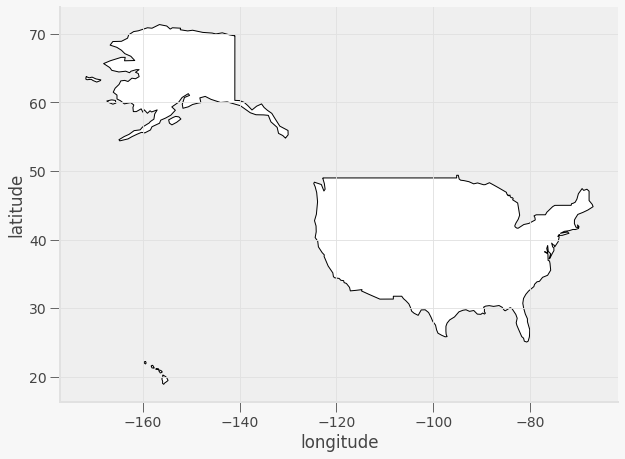

In [16]:
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot SA.
world.query("name == 'United States of America'").plot(ax=gax, edgecolor='black',color='white')

# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

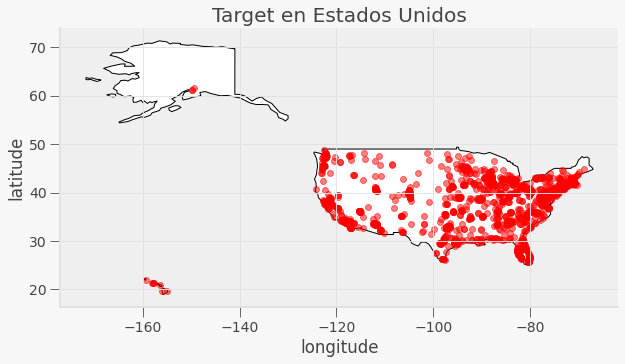

In [17]:
# Step 3: Plot the cities onto the map
# We mostly use the code from before --- we still want the country borders plotted --- and we
# add a command to plot the cities
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gdf.plot(ax=gax, color='red', alpha = 0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

¿qué tal ahora?, tiene mayor sentido verdad, entonces los datos lejanos no eran atípicos, de aquí la importancia de ver los datos con el tipo de gráfica correcta.

Ahora sí, implementa K means a los datos de latitud y longitud :) y encuentra donde colocar los almacenes. 

Nota: si te llama la atención implementar alguna otra visualización con otra librería, lo puedes hacer, no hay restricciones.

In [21]:
import random
import numpy as np
import pandas as pd 
import scipy.spatial
from haversine import haversine
from sklearn.cluster import KMeans

In [37]:
latlong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1839 entries, 0 to 1838
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   1839 non-null   float64
 1   longitude  1839 non-null   float64
dtypes: float64(2)
memory usage: 28.9 KB


In [83]:
#Ajuste del modelo de vecinos cercanos
#Se prueba el ajuste para obtener un 
#numero especifico de vecinos cercanos
kmeans = KMeans(n_clusters=3)
kmeans.fit(latlong)

KMeans(n_clusters=3)

In [84]:
#Obtenemos el punto centras de cluster
centers = kmeans.cluster_centers_
print("'kmeans' model intances is trained and the cluster centroids are stored in 'centers'")
print("Number of iterations the model run to converge : {}".format(kmeans.n_iter_))

'kmeans' model intances is trained and the cluster centroids are stored in 'centers'
Number of iterations the model run to converge : 9


In [85]:
#Se despliegan los puntos centrales de los agrupamientos
#Estas son las coordenada de los almacenes
centers

array([[  37.48734203, -118.62447332],
       [  37.789554  ,  -78.56990807],
       [  37.98006261,  -93.3271723 ]])

Text(0, 0.5, 'Kmeans.inertia_')

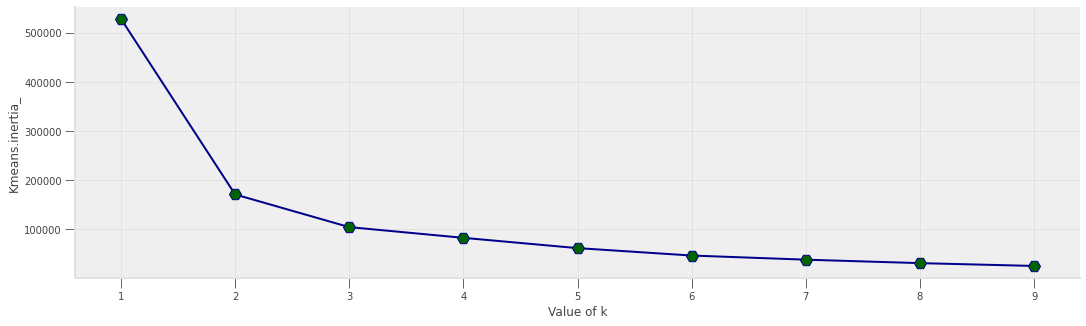

In [92]:
#Se utiliza el metodo de "Elbow", para obtener
#el numero de almacenes adecuado para abastecer 
#a las diferentes tiendas
sum_square = {}

for k in range(1, 10):
  kmeans = KMeans(n_clusters=k).fit(latlong)
  sum_square[k] = kmeans.inertia_

fig,ax = plt.subplots(figsize=(18,5))
ax.plot(list(sum_square.keys()), list(sum_square.values()),ls='-',marker='H', color='DarkBlue', lw=2,
        markersize=12,markerfacecolor = 'DarkGreen')
ax.set_xlabel("Value of k")
ax.set_ylabel("Kmeans.inertia_")

In [93]:
#Con el valor optimo de K, se entrena de nuevo el 
#modelo y se obtienen las coordenas de los centro
#de distribución
kmeans = KMeans(n_clusters=4)
kmeans.fit(latlong)

centers = kmeans.cluster_centers_
centers

array([[  36.557344  ,  -84.8119487 ],
       [  37.57757741, -119.14645561],
       [  36.99505521,  -96.97278809],
       [  40.33224701,  -75.27553283]])

In [157]:
#Se realiza un conteopara determinar 
#cuantas tiendas atendea cada centro de distribución
conteo=kmeans.labels_
conteo

array([0, 0, 0, ..., 2, 2, 1], dtype=int32)

In [156]:
np.bincount(conteo)

array([615, 369, 401, 454])

In [101]:
#Se obtienen las nuevas coordenas
new_latlong = pd.DataFrame(centers, columns =['Latitude','Longitude'])
new_latlong

,Latitude,Longitude
0,36.557344,-84.811949
1,37.577577,-119.146456
2,36.995055,-96.972788
3,40.332247,-75.275533


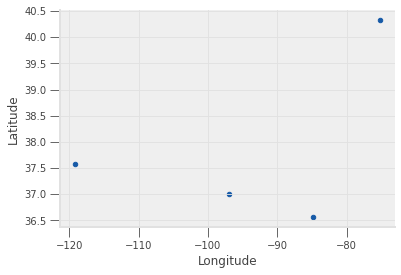

In [102]:
#Se graficas en una grafica de dispersion
#al parecer no tienen mucho sentido
new_latlong.plot.scatter( "Longitude","Latitude")

In [106]:
#Se agregan datos ala nueva tabla de coordenadas
new_latlong["Coordinates"] = list(zip(new_latlong.Longitude, new_latlong.Latitude))
new_latlong["Coordinates"] = new_latlong["Coordinates"].apply(Point)
new_latlong.head()

,Latitude,Longitude,Coordinates
0,36.557344,-84.811949,POINT (-84.81194869642276 36.55734399853659)
1,37.577577,-119.146456,POINT (-119.14645561138212 37.57757741219512)
2,36.995055,-96.972788,POINT (-96.97278808975 36.99505520875)
3,40.332247,-75.275533,POINT (-75.27553282527472 40.33224701032967)


In [108]:
#Se genera el nuevo dataframe de datos geograficos con las coordenadas nuevas
gedf = gpd.GeoDataFrame(new_latlong, geometry="Coordinates")
gedf.head()

,Latitude,Longitude,Coordinates
0,36.557344,-84.811949,POINT (-84.81195 36.55734)
1,37.577577,-119.146456,POINT (-119.14646 37.57758)
2,36.995055,-96.972788,POINT (-96.97279 36.99506)
3,40.332247,-75.275533,POINT (-75.27553 40.33225)


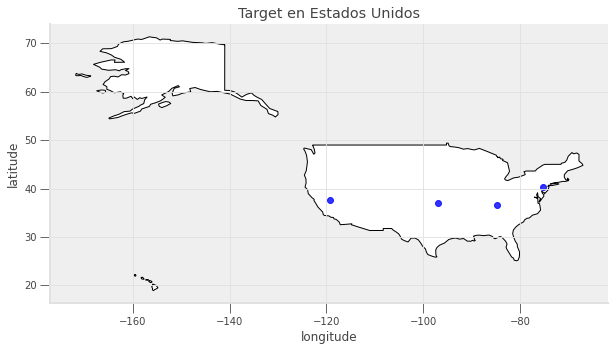

In [114]:
#Se grafica solo los almacenes
fig, gax = plt.subplots(figsize=(10,10))

# By only plotting rows in which the continent is 'South America' we only plot, well,
# South America.
world.query("name == 'United States of America'").plot(ax = gax, edgecolor='black', color='white')

# This plot the cities. It's the same syntax, but we are plotting from a different GeoDataFrame.
# I want the cities as pale red dots.
gedf.plot(ax=gax, color='blue', alpha = 0.8)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Target en Estados Unidos')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

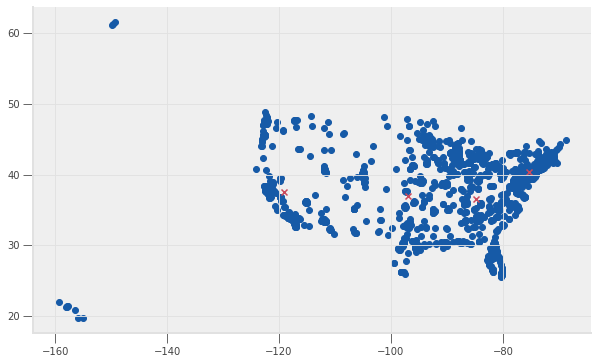

In [116]:
#Posicion de las tienda y de los almacenes
#Grafica de dispersión
fig, ax = plt.subplots(figsize=(10, 6))
plt.scatter(latlong.longitude,latlong.latitude)
plt.scatter(new_latlong.Longitude, new_latlong.Latitude,marker='x')

In [137]:
#Ubicacion o dirección de los almacenes
geolocator = Nominatim(user_agent="geoapiExercises")
location_1 = geolocator.reverse("36.557344, -84.811949")
print(location_1)
location_2 = geolocator.reverse("37.577577, -119.146456")
print(location_2)
location_3 = geolocator.reverse("36.995055, -96.972788")
print(location_3)
location_4 = geolocator.reverse("40.332247, -75.275533")
print(location_4)

Spaughs Ridge Road, Pickett County, Tennessee, United States
Mammoth Trail, Madera County, California, United States
332nd Road, Cowley County, Kansas, United States
Diamond Street, Hilltown Township, Bucks County, Pennsylvania, 18962, United States


Encuentra el numero ideal de almacenes, justifica tu respuesta.

Encuentra las latitudes y longitudes de los almacenes, ¿qué ciudad es?,  ¿a cuantas tiendas va surtir?

1. 36.557344	-84.811949	Tennessee    615
2. 37.577577	-119.146456 California   309
3. 36.995055	-96.972788  Kansas       401
4. 40.332247	-75.275533	Pensilvania  454

¿Sabes a qué distancias estará? La pregunta no es muy clara o especifica, pero cada la distancia entre el almacén de California y Kansas es de 1536 millas, la distancia del almacén de Kansas al de Tennessee es de 878 millas, y del de Tennessee a Pensilvania de 833 millas. Observamos que la distancia es equidistante entre tres de los cuatro puntos. Con la excepción de la distancia de California a Kansas, pero se justifica de cierta manera porque el número de almacenes que se encuentra en área geográfica es menor.


¿Cómo elegiste el número de almacenes? Utilizando algoritmo de vecinos cercanos, específicamente método de codo "elbow", este nos indica gráficamente que el número ideal de almacenes se encuentra entre 4 y 5, para nuestro caso nosotros seleccionamos 4, nos pareció más adecuado que cuatro las distancias entre los puntos son similares, lo que pensamos minimizara los costos en logística.

Adicionalmente, en el notebook notaras que al inicio exploramos los datos y los graficamos de manera simple, después nos auxiliamos de una librería de datos geográficos.

¿Qué librerías nos pueden ayudar a graficar este tipo de datos?

1. **Geopy** esta librería nos permite obtener la localización o dirección una vez que obtenemos las coordenadas de latitud y longitud, utilizada en la práctica.

2. **Plotly/Plotly Express** esta librería nos permite colocar líneas en los mapas, seleccionar áreas, colocar burbujas, sobreponer mapas de densidad, colocar información sobre punto de interés en los mapas, gráficas de dispersión sobre los mapas, entre algunas otras amenidades. Es una API de alto nivel.

3. **Folium** esta librería permite la manipulación en Python de forma interactiva los mapas o datos sobre estos. La librería permite dado un par de coordenadas generar el mapa de la zona donde esta se encuentra, y salvarla en archivo html, permite colocar diferentes tipos de marcadores sobre el mapa, diferentes tipos de vistas de los mapas, permite seleccionar zonas geográficas y etiquetarlas en burbujas, permite colocar transparencias sobre el mapa y realizar mapas de calor en una determinada zona geográfica. Además cuenta con funciones que permiten la personalización de la vista de los mapas.


¿Consideras importante que se grafique en un mapa?, ¿por qué? Si considero que es importante que estos datos se grafiquen en un mapa porque nos ayuda ver la distribución de los datos, a identificar en que regiones se concentra mayor cantidad de datos, observar en que regiones hay una distribución menor de datos, identificar datos que pensamos son outliers, y no lo son, a identificar áreas geográficas en donde no se presentan ningún dato.

**Conclusiones**
El algoritmo de vecinos cercanos son permite realizar agrupaciones de datos y encontrar el centro de estos datos, esto lo logra por medio de la distancia entre los vecinos cercanos. Este algoritmo en comparación con los algoritmos de clasificación se encuentra en la categoría de los algoritmos sin supervisión, el algoritmo se encarga de realizar el etiquetado de las muestras, en comparación con los algoritmos supervisados en donde es necesario que los datos se encuentren etiquetados. El ejercicio desarrollado es un gran ejemplo de la capacidad que tienen este algoritmo en particular, sobre todo cuando necesitamos determinar algo y solamente tenemos nuestros datos sin etiquetar, vecinos cercanos es la opción adecuada. Este algoritmo se complementa con la estrategia de búsqueda de "elbow", con la cual se determina el número "K" adecuado para el entrenamiento del modelo.
